In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as plotly_express
from sklearn import decomposition
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import ListedColormap

In [4]:
#load the data

curr_dir=os.getcwd()
f_path = os.path.join(curr_dir, "data", "cancer patient data sets.csv")

df=pd.read_csv(f_path)
df['Level_hot_encode'] = df['Level'].apply(lambda x: ["Low", "Medium", "High"].index(x))
features = df.drop(["index","Patient Id","Level", "Level_hot_encode"], axis=1)
df.head()


,index,Patient Id,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,...,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level,Level_hot_encode
0,0,P1,33,1,2,4,5,4,3,2,...,4,2,2,3,1,2,3,4,Low,0
1,1,P10,17,1,3,1,5,3,4,2,...,3,7,8,6,2,1,7,2,Medium,1
2,2,P100,35,1,4,5,6,5,5,4,...,7,9,2,1,4,6,7,2,High,2
3,3,P1000,37,1,7,7,7,7,6,7,...,2,3,1,4,5,6,7,5,High,2
4,4,P101,46,1,6,8,7,7,7,6,...,2,4,1,4,2,4,2,3,High,2


In [5]:
# final selected features from feature selection (method2b)
final_features_method2b = ['Age',
 'Alcohol use',
 'Smoking',
 'chronic Lung Disease',
 'Fatigue',
 'Coughing of Blood',
 'Chest Pain',
 'Genetic Risk',
 'OccuPational Hazards',
 'Shortness of Breath',
 'Weight Loss',
 'Clubbing of Finger Nails',
 'Dry Cough',
 'Wheezing']


# Proving linear separability of our dataset
Since we achieved a model accuracy of 100% using a linear SVM model, we aim to prove that our data is linearly separable.

## Method 1: PCA
We attempt to prove that a linear model is sufficient to predict our class labels using prinicipal component analysis (PCA)
- Attempt 1: Prove linear separability using the whole feature set 
- Attempt 2: Prove linear separability using selected features from method 2b

### Define functions 
- pca_tranform performs PCA on a feature set (x), where n_comp is the number of principal components to keep. This means that n_comp is the number of dimensions that we would like to reduce the feature space to. We also append the class labels for ease of visualisation.

- plot_PCA_2D and plot_PCA_3D takes in the output of pca_transform and plots for all datapoints where PC1 against PC2 and PC1 against PC2 against PC3 respectively

- Additionally, each datapoint is colored with its class label to observe the class separation (if any).


In [44]:
def pca_transform(x, y, n_comp):
  pc_list = [f"PC{i+1}" for i in range(n_comp)]
  pca = decomposition.PCA(n_components=n_comp)
  pc = pca.fit_transform(x)
  pc_df = pd.DataFrame(data=pc,columns=pc_list)
  pc_df['Label'] = y
  return pc_df, pca, pc_list

def plot_PCA_2D(pc_df, pca, pc_list):
    var = pd.DataFrame({'Variance':pca.explained_variance_ratio_,'PC':pc_list})
    fig,ax = plt.subplots(1,2,figsize=(12,5))
    
    sns.barplot(x='PC',y="Variance", data=var,ax=ax[0])
    for i in ax[0].containers:
       ax[0].bar_label(i,fmt='%.2f')

    sns.scatterplot( x="PC1", y="PC2",data=pc_df, hue='Label',legend=True,ax=ax[1],s=50)

def plot_PCA_3D(pc_df, pca):
    pca_var_sum=sum(pca.explained_variance_ratio_[:4])
    figure = plotly_express.scatter_3d(pc_df,x="PC1",y="PC2",z="PC3",color="Label")
    figure.update_layout(showlegend=True)
    figure.show()

### Attempt 1: All features 

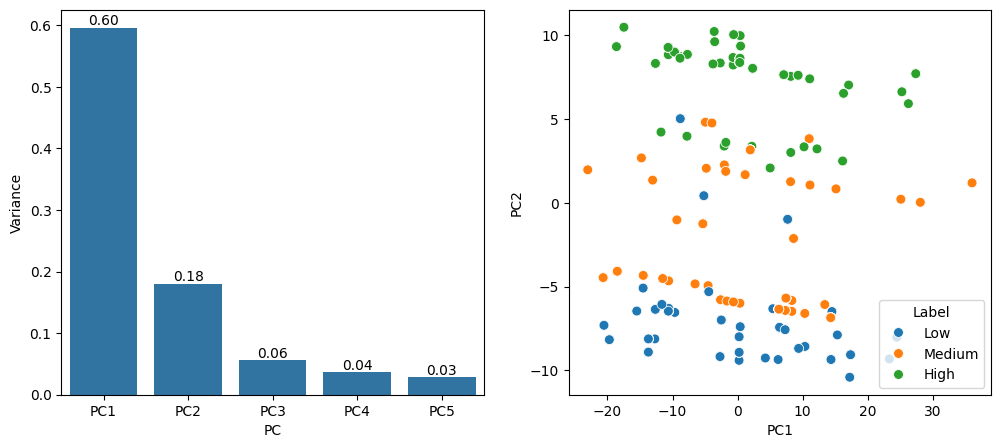

In [45]:
n_comp=5
y=df["Level"]
pc_df, pca, pc_list= pca_transform(features, y, n_comp)
plot_PCA_2D(pc_df, pca, pc_list)

*Figure X. PCA results generated using the full dataset and all its features. (Left) Barplot indicating the variance per Principal Component, with PC1 and PC2 having a high cumulative variance of 78%. (Right) Unclear separation of classes shown in the scatterplot generated using PC1 and PC2.*

First, we observe the overall PCA separation of all datapoints. Based on Figure X (Left), we observe that the principal components PC1, PC2, and PC3 explains 60%, 18%, and 6% respectively of the total variance in the original dataset.

From Figure X (Right), we observe that datapoints with "Low" label is clearly separated from datapoints with "High" label. However, we observe that some datapoints with "Medium" labels overlap with those with either "Low" or "High" labels. This suggest that PC1 and PC2 are less unable to discern "Medium" labels from "Low" and "High" labels. This observation is also apparent in the 3D plot shown in Figure X. 

In [14]:
plot_PCA_3D(pc_df, pca)

*Figure X. Unclear separation of classes shown in the 3D PCA plot of PC1, PC2, PC3 generated from the full dataset and all its features.*

#### Attempt to prove pairwise separability of labels 
Since "Low" and "High" labels are clearly linear separable, it remains to be seen that ("Low" and "Medium") and ("Medium" and "High") labels are linear separable as well. 

To do so, remove one of the class labels to perform one vs one classificaiton. For example, remove "High" label to check linear separability of "Low" and "Medium" labels only. 

##### Low vs Medium

(635, 23)


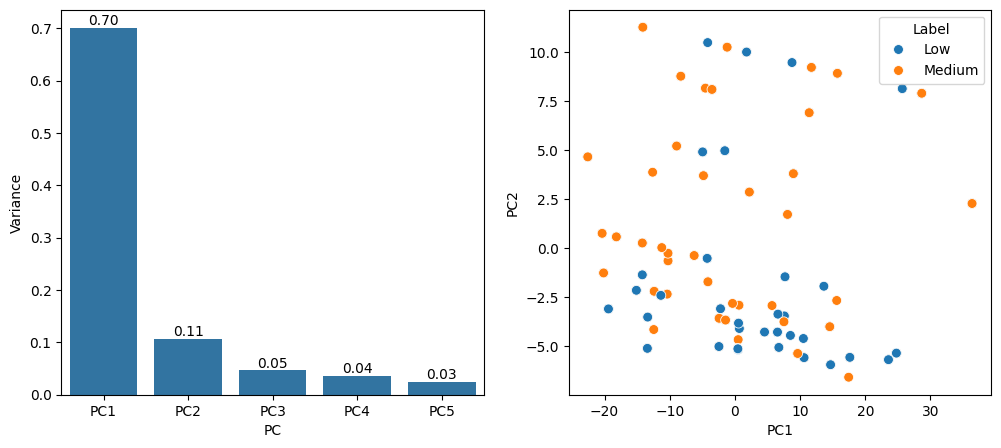

In [46]:
df_low_medium = df.loc[df["Level"].isin(["Low","Medium"])]
x=df_low_medium.drop(["index","Patient Id","Level", "Level_hot_encode"], axis=1)
x=x[features.columns]
print(x.shape)
y=df_low_medium["Level"]
n_comp=5
pc_df, pca, pc_list= pca_transform(x, y, n_comp)
plot_PCA_2D(pc_df, pca, pc_list)

*Figure X. PCA results generated using all features and the subset of datapoints labeled Low and Medium only. (Left) Barplot indicating the variance per Principal Component, with PC1 and PC2 haing a high cumulative variance of 81%. (Right) Poor separation of classes shown in the scatterplot generated using PC1 and PC2.*

In [17]:
plot_PCA_3D(pc_df, pca)

*Figure X. Poor separation of classes shown in the 3D PCA plot of PC1, PC2, PC3 generated using all features and the subset of datapoints labeled Low and Medium only.*

##### Medium vs High

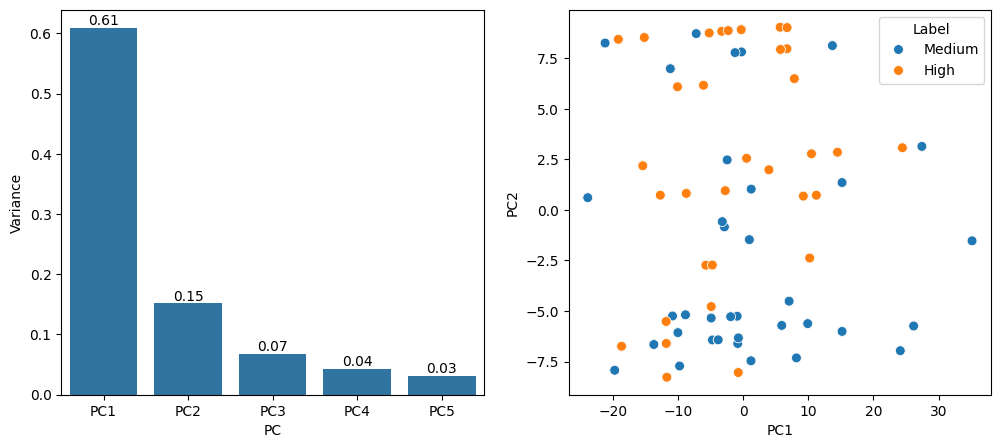

In [47]:
df_medium_high = df.loc[df["Level"].isin(["Medium","High"])]
x=df_medium_high.drop(["index","Patient Id","Level", "Level_hot_encode"], axis=1)
x=x[features.columns]
y=df_medium_high["Level"]
n_comp=5
pc_list = [f"PC{i+1}" for i in range(n_comp)]
pc_df, pca, pc_list= pca_transform(x, y, n_comp)
plot_PCA_2D(pc_df, pca, pc_list)

*Figure X. PCA results generated using all features and the subset of datapoints labeled Medium and High only. (Left) Barplot indicating the variance per Principal Component, with PC1 and PC2 haing a high cumulative variance of 81%. (Right) Poor separation of classes shown in the scatterplot generated using PC1 and PC2.*

In [19]:
plot_PCA_3D(pc_df, pca)

*Figure X. Poor separation of classes shown in the 3D PCA plot of PC1, PC2, PC3 generated using all features and the subset of datapoints labeled Medium and High only.*

We observe that in both cases, removing one of the class labels resulted in worse separation by PCA, where the linear boundary is non-existent (Figures X and X). This was also apparent in the subsequent 3D plots, even though an additional PC was included (Figures X and X) This suggest that the datapoints from the removed class play an important role in the model's ability to accurately predict all class labels. When we remove one of the classes, we are discarding around 30% of our dataset which essentially decreases the variability of the set. Since PCA aims to maximise variance, the overall decrease in variability of our dataset may have hindered the ability of PCA to identify principal components that separate our data. 

### Attempt 2: Selected features

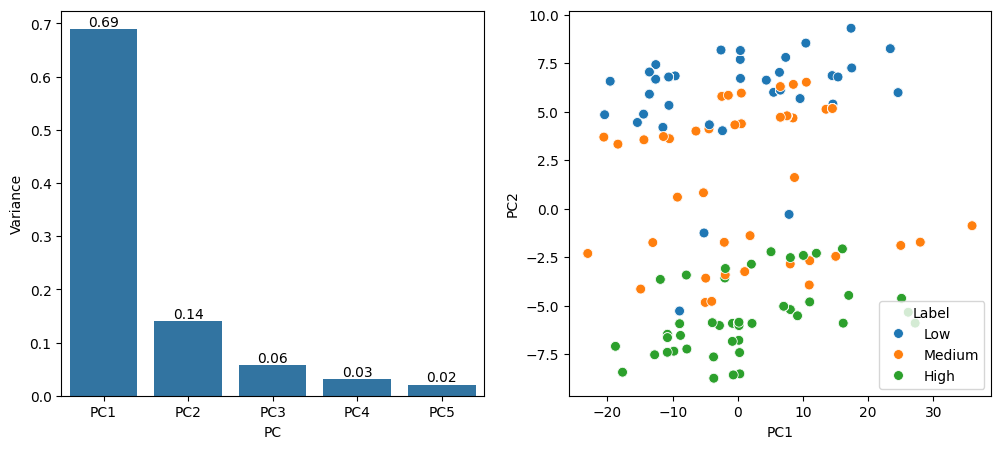

In [48]:
n_comp=5
x = features[final_features_method2b]
y = df["Level"]
pc_df, pca, pc_list= pca_transform(x, y, n_comp)
plot_PCA_2D(pc_df, pca, pc_list)

*Figure X. PCA results generated using the full dataset and selected features from Method 2b. (Left) Barplot indicating the variance per Principal Component, with PC1 and PC2 having a high cumulative variance ratio of 83%. (Right) Unclear separation of classes shown in the scatterplot generated using PC1 and PC2.*

In [22]:
plot_PCA_3D(pc_df, pca)

*Figure X. Poor separation of classes shown in the 3D PCA plot of PC1, PC2, PC3 generated using the full dataset and the selected features from Method 2b.*

The cumulative variance of PC1 and PC2 using the features selected in method 2b was 83% (Figure X), higher than that of attempt 1 with 78% cumulative variance (Figure X). However, we observe that the overall PCA results are almost similar to that of attempt 1 (Figure X). 

## Method 2: LDA
Since PCA did not seem to adequately prove linear separability of our dataset, we moved on to try Linear Discriminant Analysis (LDA). PCA is an unsupervised method which aims to capture the direction of maximum variance in the data. On the other hand, LDA is a supervised method which aims to find the projection that maximises class separability while minimising the variance within each class. Hence, LDA could better identify the linear boundary between classes. 

### Define functions
- The custom LDA function can be broken down into 3 main parts. First, we used scikit-learn library's LinearDiscriminantAnalysis model to fit and transform our training dataset. Second, we extract the explained and cumulative variance ratio from the linear discriminants. The explained variance ratio descibes the variance captured by each linear discriminant while the cumulative variance ratio describes the accumulation of variance for each linear discriminant. Since we have 3 classes, the maximum number of linear discriminants that we can find is 2 (max linear discriminants = no. of class labels - 1). Last, we plot the cumulative explained variance against the number of linear discriminants to understand the amount of variance in the dataset that is captured by LDA.

- The custom SVM function provides a visual representation of how well the SVM classifier seperates the 3 classes in the datasets based on features from LDA transformation. It can be broken down into 2 main parts. First, we fit that dataset using the same baseline SVM model and computes the model's accuracy. Subseuqnetly, it creates two subplots to visualise the decision boundary for both training and testing sets. In each subplot, it predicts a class labels using the trained SVM classifier and plots the data points coloured by the class to illustrate how the decision boundaries separates different classes.

In [58]:
def LDA(X_train, X_test,y_train):
    # Fit and transform 
    lda = LinearDiscriminantAnalysis()
    X_train_lda = lda.fit_transform(X_train, y_train)
    X_test_lda = lda.transform(X_test)
    # Cumulative variance + explained variance 
    explained_var_ratio=lda.explained_variance_ratio_
    cumulative_var_ratio=np.cumsum(explained_var_ratio)
    lda_df = pd.DataFrame()
    lda_df['Cumulative Variance Ratio'] = cumulative_var_ratio
    lda_df['Explained Variance Ratio'] = explained_var_ratio
    display(lda_df)
    # Plot 
    sns.set(style='whitegrid')
    plt.plot(cumulative_var_ratio)
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()

    return X_train_lda, X_test_lda

def SVM_visualisation(X_train_lda,X_test_lda, y_train,y_test):
    linear_clf = svm.SVC(kernel="linear", decision_function_shape='ovo', probability=True)
    linear_clf.fit(X_train_lda, y_train)
    y_pred = linear_clf.predict(X_test_lda)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: ", accuracy)

    # Training results 
    X_set, y_set = X_train_lda, y_train

    X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                        np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
    X1 = np.array(X1, dtype=float)
    X2 = np.array(X2, dtype=float)
    input_array = np.column_stack((X1.ravel(), X2.ravel()))
    Z = linear_clf.predict(input_array)
    Z = Z.reshape(X1.shape)
    Z = np.array(Z, dtype=float)

    fig, ax = plt.subplots(1,2,figsize=(12,5))
    
    ax[0].contourf(X1, X2, Z, alpha=0.75, cmap=ListedColormap(('red', 'green', 'blue')))
    ax[0].set_xlim(X1.min(), X1.max())
    ax[0].set_ylim(X2.min(), X2.max())
    for i, j in enumerate(np.unique(y_set)):
        label = df[df["Level_hot_encode"]==j].iloc[0]["Level"]
        ax[0].scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                    c = ListedColormap(('red', 'green', 'blue'))(i), label = label)
    ax[0].set_title('SVC (Training set)')
    ax[0].set_xlabel('LD1')
    ax[0].set_ylabel('LD2')

    # Testing results 
    X_set, y_set = X_test_lda, y_test

    X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                        np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
    X1 = np.array(X1, dtype=float)
    X2 = np.array(X2, dtype=float)
    input_array = np.column_stack((X1.ravel(), X2.ravel()))
    Z = linear_clf.predict(input_array)
    Z = Z.reshape(X1.shape)
    Z = np.array(Z, dtype=float)
    
    ax[1].contourf(X1, X2, Z, alpha=0.75, cmap=ListedColormap(('red', 'green', 'blue')))
    ax[1].set_xlim(X1.min(), X1.max())
    ax[1].set_ylim(X2.min(), X2.max())
    for i, j in enumerate(np.unique(y_set)):
        label = df[df["Level_hot_encode"]==j].iloc[0]["Level"]
        ax[1].scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                    c = ListedColormap(('red', 'green', 'blue'))(i), label = label)
    ax[1].set_title('SVC (Testing set)')
    ax[1].set_xlabel('LD1')
    ax[1].set_ylabel('LD2')
    plt.legend()
    plt.show()
    

### Attempt 1: All features

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.881365,0.881365
1,1.000000,0.118635


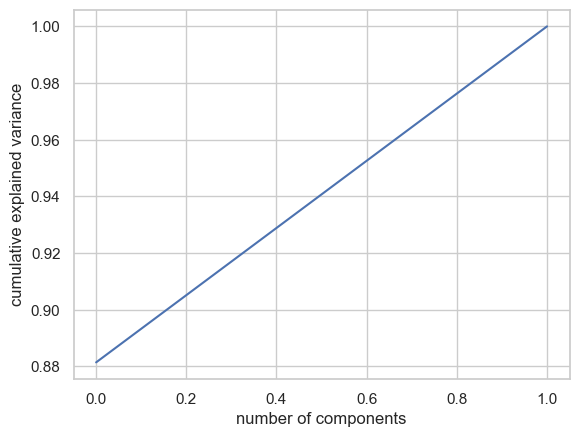

In [60]:
x = features
y = df["Level_hot_encode"]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_train_lda, X_test_lda = LDA(X_train, X_test, y_train)

*Figure X. 100% cumulative variance from LD1 and LD2, generated using the full dataset and all its features.*

We observe that the explained variance ratio of LD1 and LD2 are 88% and 12% respectively. Further, the cumulative variance ratio of LD1+LD2 is 100% (Figure X). This suggest that LD1 and LD2 are able to capture all the variance in the dataset.

Accuracy:  0.97


/var/folders/2h/x068fsqx03zbclmdr9v03rf80000gn/T/ipykernel_51417/1618203580.py:48: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[0].scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
/var/folders/2h/x068fsqx03zbclmdr9v03rf80000gn/T/ipykernel_51417/1618203580.py:71: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[1].scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],


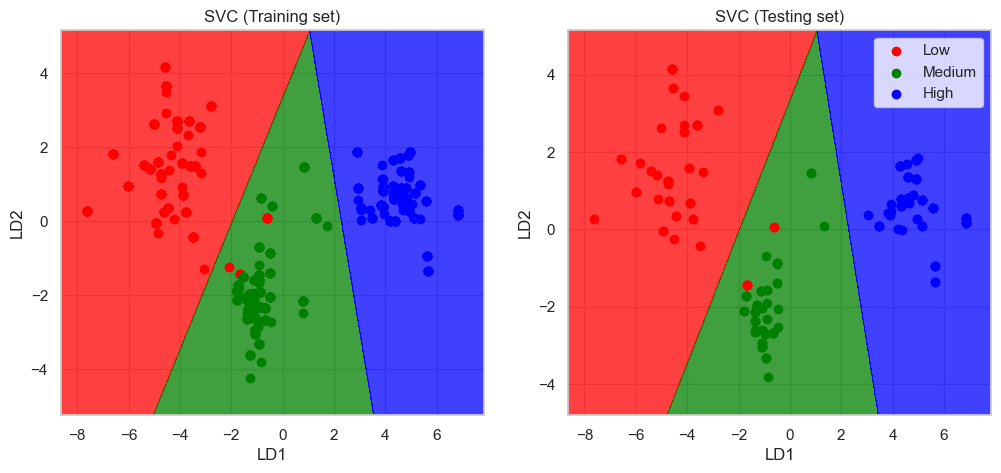

In [61]:
SVM_visualisation(X_train_lda,X_test_lda, y_train,y_test)

*Figure X. SVM trained on features transformed by LDA (using the full dataset and all its features). Clear boundaries between classes with few misclassifications of datapoints labeled Low.*

From Figure X, we see that clusters form based on their class label with a clear linear boundary between each class label. However, we see that some datapoints with label "Low" are falsely predicted to be of "Medium" label, which also explains the slightly lower model accuracy of 97%. The lower model accuracy may be attributed to the high number of features (i.e. curse of dimensionality), leading to lower model performance.

### Attempt 2: Selected features 
The curse of dimensionality happens when we have too many features but insufficient data to generalise a model accurately. In our case, we have 23 features but only 1000 datapoints, which may result in lower model performance, particularly when employing dimensionality reduction techniques like LDA. Moreover, many features may add irrelevant information, increasing the signal-to-noise ratio. Hence, it is impactful to observe whether using a selected set of features, followed by compression via LDA, could improve the results of linear separability of our data. 

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.937679,0.937679
1,1.000000,0.062321


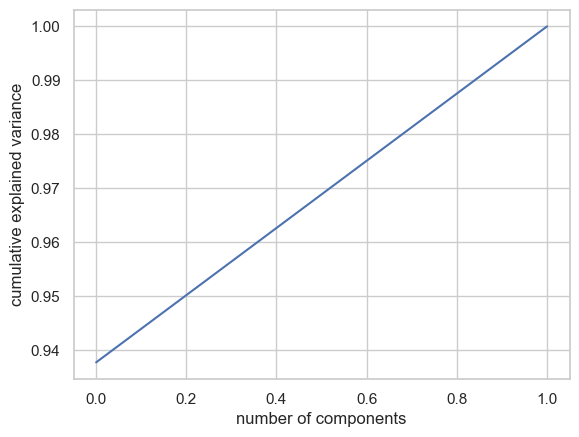

In [56]:
x = features[final_features_method2b]
y = df["Level_hot_encode"]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

X_train_lda, X_test_lda = LDA(X_train, X_test, y_train)

*Figure X. 100% cumulative variance from LD1 and LD2, generated using the full dataset and selected features from Method 2b.*

We observe that the explained variance ratio of LD1 and LD2 are 93% and 6% respectively. Compared to attempt 1, LDA1 (attempt 2) explains more variance of the data, suggesting that feature extraction does help to improve the model's ability to learn the features of the data. Similarly, we observe a cumulative variance ratio of 100%.

Accuracy:  0.99


/var/folders/2h/x068fsqx03zbclmdr9v03rf80000gn/T/ipykernel_51417/1618203580.py:48: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[0].scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
/var/folders/2h/x068fsqx03zbclmdr9v03rf80000gn/T/ipykernel_51417/1618203580.py:71: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[1].scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],


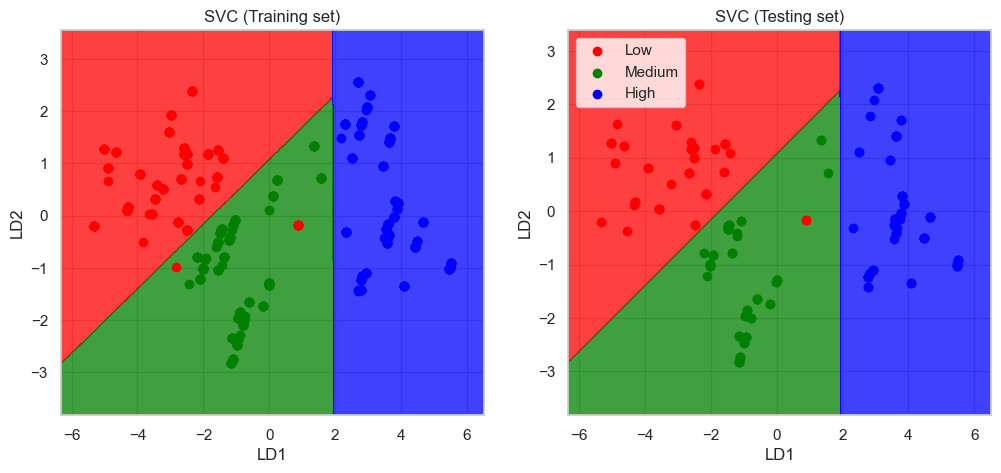

In [57]:
SVM_visualisation(X_train_lda,X_test_lda, y_train,y_test)

*Figure X. SVM trained on features transformed by LDA (using the full dataset and features selected from Method 2b). Clear boundaries between classes with few misclassifications of datapoints labeled Low.*

From the SVC plots, we see that clusters form based on their class label with a clear linear boundary between each class label. Compared to attempt 1, we observe fewer data points with the "Low" labels that are wrongly predicted as "Medium". This is further supported by a higher model accuracy of 99%. Overall, we can conclude that the selected features are not only sufficient to prove linear separability of our data but also help improve the training of the model.